<a href="https://colab.research.google.com/github/dbwilburn/BIOC5721/blob/main/NLLS_Thermodynamics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## NLSS Thermodynamics

#### DBW 11/13/23

### This notebook is a companion to [this notebook](https://github.com/mpfoster/Biochem5721/blob/master/Intro_fitting_kinetics_5721_au23.ipynb) introducing least squares regression


In [55]:
## Libraries we will use in this script
import numpy as np, pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from matplotlib.font_manager import FontProperties

import scipy.stats as stats

from scipy.optimize import curve_fit

In [6]:
# Define our first order rate function

def first_order_rate(x,A,k):
  # two-parameter exponential decay, with amplitude A
  return A*np.exp(-x*k)

In [1]:
# use pandas to load the data from a local file

datafile = 'https://github.com/mpfoster/Biochem5721/raw/master/Data/penicillin-data.csv' # Either local files or web addresses can be loaded
df = pd.read_csv(datafile) # here, assumes file in current directory
df  # show the contents of the data frame

,Time_weeks,Penicillin_U
0,0.0,10100
1,1.0,8180
2,2.0,6900
3,3.0,5380
4,4.0,4320
5,5.0,3870
6,7.0,2190
7,8.0,2000
8,9.0,1790
9,10.0,1330


Text(0, 0.5, 'Penicillin Units')

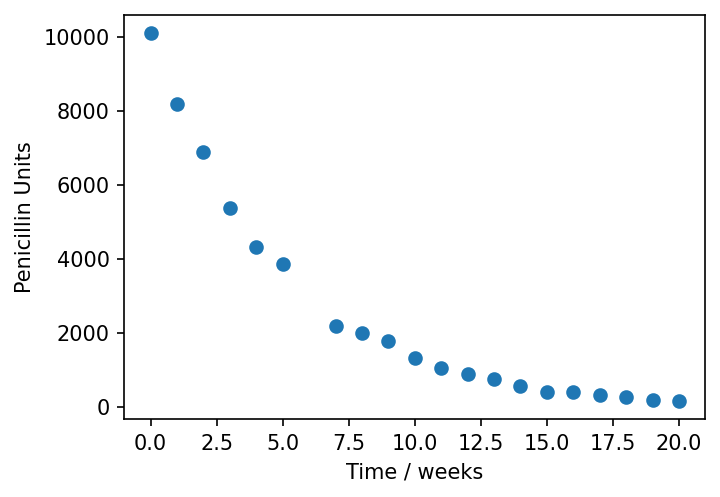

In [9]:
# read the data from the df into variables and plot
xdata = df['Time_weeks']
ydata = df['Penicillin_U']

fig,ax = plt.subplots( figsize=(5,3.5), dpi=150 ) # Configure figure size and resolution in dots per inch (dpi)
ax.plot(xdata, ydata, 'o') # plot the data using a scatter plot
ax.set_xlabel('Time / weeks')
ax.set_ylabel('Penicillin Units')

## Nonlinear regression, or specifically *Non-Linear Least Squares (NLSS)* regression like we will be performing, is the most popular approach to find the parameters that best explain our data.

### How do we *mathematically* define the "best" parameters? As we will see, we do this by finding the parameters that have the *lowest free energy*

### As you saw in `Intro_fitting_kinetics_5721.ipynb`, we can find the optimal parameters for a model by running `curve_fit`, which takes 4 required inputs:

####  1. Independent features (`xdata`)
#### 2. Dependent features (`ydata`)
####  3. A model (`first_order_rate`)
#### 4. Initial guesses of model parameters (`p0`)



### The final requirement, `p0`, is a list/tuple of ***guesses*** for the parameters of our model (`first_order_rate`). Since our function has parameters `A` and `k`, we need to provide $A_{guess}$ and $k_{guess}$ from which the "free energy" can be minimized. 

Optimal A = 10099.7; Optimal k = 0.204; Half-life = 3.4 weeks


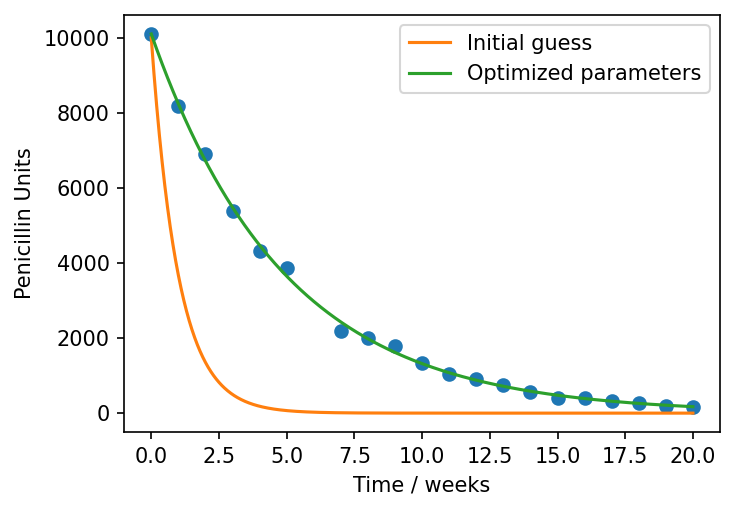

In [16]:

p0 = (1e4,1.0) # (A_guess, k_guess)
popt,pcov = curve_fit(first_order_rate,xdata,ydata, p0 = p0) # Returns optimal parameters (k_best,A_best) and their covariance matrix

xlim = (0,20)


fig,ax = plt.subplots( figsize=(5,3.5), dpi=150 ) # Configure figure size and resolution in dots per inch (dpi)
ax.plot(xdata, ydata, 'o') # plot the data using a scatter plot
ax.set_xlabel('Time / weeks')
ax.set_ylabel('Penicillin Units')

# Plot our "guess" of the best fit line (p0) versus the optimized parameters (popt)
xt = np.linspace( *xlim, 1000 ) # Generate 1000 points between 0 and 20
y0 = first_order_rate(xt, *p0)
ax.plot(xt,y0, label='Initial guess')
yopt = first_order_rate(xt, *popt)
ax.plot(xt,yopt, label='Optimized parameters')

ax.legend()
fig.tight_layout()

A_opt, k_opt = popt
half_life = np.log(2)/k_opt
print( f'Optimal A = {popt[0]:.6}; Optimal k = {k_opt:.3}; Half-life = {half_life:.3} weeks')


### By running an *optimization routine* using our starting parameters `p0` as a starting point, `curve_fit` runs multiple cycles of optimization to gradually improve our starting parameters till additional changes will no longer provide any improvement.

#### As we can see, our $A_{guess} = 10,000$ was optimized to $A_{opt} = 10099.7$ and $k_{guess} = 1.0$ was optimized to $k_{opt} = 0.204$
#### Similarly our guess of *Half-life ~ 3 weeks* wasn't too far off (3.4 weeks)

### The optimization routine used by `curve_fit` is one of many flavors of **gradient-based methods** that use the partial derivatives of a **Loss function** relative to each parameter to compute the direction of optimization. The **Loss function** is also known as our **Error function** and is mathematically identical to **Free Energy**

### To demonstrate how this works, let us ***build our own gradient optimization routine***, which requires we first define our **Loss function**

### The most commonly used loss function is the **Mean squared error (MSE)**, or the *sum of squared residuals between our observed data points and model fits*

## For a function ***f*** with free parameters ***$\theta$***, given some set of inputs ***x*** and outputs ***y***:
## $MSE(\theta) = \Sigma_{i}{(y_i-f(x|\theta))^2}$

## And our objective is to find parameters $\theta_{opt} = (A_{opt},k_{opt})$ such that $MSE(\theta_{opt}) \le MSE(\theta_{any})$

### Since our function $f(x|\theta)$ is our `first_order_rate` ($A=e^(-kt)$), we *could* try to compute the partial derivatives $\frac{\partial MSE(\theta)}{\partial A}$ and $\frac{\partial MSE(\theta)}{\partial k}$ to determine the **the direction and magnitude by which changing the parameters will increase or decrease the error by small parameter step**. But, this can be somewhat tedious, and we would similarly have to do this calculation for any other functions besides `first_order_rate` we may want to optimize. Instead, we can estimate the partial derivatives using ***numerical methods***

### Since our partial derivatives is the instantaneous rate of change of our dependent variable relative to one of our independent variables (holding all other variables constant), we can *numerically estimate* our partial derivatives using the $\delta$-$\epsilon$ method. The partial derivative along all parameters in a model is often called the **gradient**, upon which we will perform **gradient descent** to find the optimal parameters

In [36]:
def MSE(true,pred):
    return np.mean((true-pred)**2)

def compute_average_gradient(func, x, y, p0, eps=1e-5):
    '''
    For a provided func, estimate the partial derivative for each parameter
    in p0 using eps as the change in each parameter PER OBSERVATION, which
    we will then avearge across all observations
    '''
    gradients = []
    for i, p in enumerate(p0): # Returns both the index i and parameter p from the list p0
        pred_0 = func(x,*p0)
        MSE_0 = MSE(y, pred_0)
        p_eps = list(p0) # Copy the list
        p_eps[i] = p + eps # Shift our focal parameter by some small value
        pred_eps = func(x,*p_eps)
        MSE_eps = MSE(y, pred_eps)

        partial_d = (MSE_eps-MSE_0)/eps # delta_y / delta_x
        gradients.append(partial_d)
    return gradients


gradients = compute_average_gradient(first_order_rate, xdata, ydata, p0)
print( f'dMSE/dA = {gradients[0]}; dMSE/dk = {gradients[1]}')


dMSE/dA = -285.3980287909508; dMSE/dk = 4339726.952649653


### So from this, we can infer that *increasing** ***A*** by a small value will *decrease* our MSE (i.e. improve the model), while *increasing* ***k*** will *increase* our MSE. Therefore, we should ***increase A*** and ***decrease k*** (which is what we know `curve_fit` did).

### But beyond the direction, we've also learned something about the **magnitudes** of the effect sizes. Since **eps = 1e-5**, this means if we ***increase A from 10000 to 10000.00001***, we should reduce the MSE by 285 units. If we ***decrease k from 1 to 0.99999*** then the MSE will decrease 4.3e6 ($~10^4$ times more than A!). But part of this is a natural consequence of the *magnitude* difference between A and k ($~10^4$). Therefore, when performing parameter optimizations, its more efficient to perform optimizations in log space, which we will demo later. In the meantime, let's see if we can actually optimize by just simply decreasing our model by steps of 1e-4 

In [35]:
def optimize_parameters_by_fixed_eps(func, x, y, p0, n_steps, eps):
    p_opt = list(p0) # Copy our original parameters
    for n in range(n_steps):
        gradients = compute_average_gradient(func, x, y, p_opt)
        for i, g in enumerate(gradients):
            p_opt[i] -= np.sign(g)*eps
    return p_opt

p0 = (1e4,1.0)

N_optimization_trials = int(1e4)
eps = 1e-4
p_fit = optimize_parameters_by_fixed_eps(first_order_rate, xdata, ydata, p0, N_optimization_trials, eps)

print( f'A_opt = {popt[0]}; A_fit = {p_fit[0]};0 Delta = {popt[0]-p_fit[0]}')
print( f'k_opt = {popt[1]}; k_fit = {p_fit[1]}; Delta = {popt[1]-p_fit[1]}')


A_opt = 10099.701499673052; A_fit = 10000.999999992928;0 Delta = 98.70149968012447
k_opt = 0.2036221203907627; k_fit = 0.20160000000008793; Delta = 0.0020221203906747587


Optimal A = 10099.7; Optimal k = 0.204; Half-life = 3.4 weeks


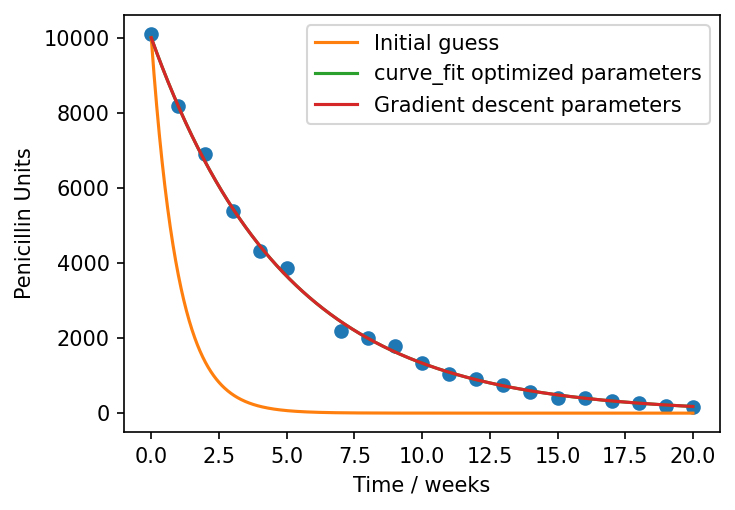

In [37]:

p0 = (1e4,1.0) # (A_guess, k_guess)
popt,pcov = curve_fit(first_order_rate,xdata,ydata, p0 = p0) # Returns optimal parameters (k_best,A_best) and their covariance matrix

xlim = (0,20)


fig,ax = plt.subplots( figsize=(5,3.5), dpi=150 ) # Configure figure size and resolution in dots per inch (dpi)
ax.plot(xdata, ydata, 'o') # plot the data using a scatter plot
ax.set_xlabel('Time / weeks')
ax.set_ylabel('Penicillin Units')

# Plot our "guess" of the best fit line (p0) versus the optimized parameters (popt)
xt = np.linspace( *xlim, 1000 ) # Generate 1000 points between 0 and 20
y0 = first_order_rate(xt, *p0)
ax.plot(xt,y0, label='Initial guess')
y_opt = first_order_rate(xt, *popt)
ax.plot(xt,y_fit, label='curve_fit optimized parameters')
y_fit = first_order_rate(xt, *p_fit)
ax.plot(xt,y_fit, label='Gradient descent parameters')

ax.legend()
fig.tight_layout()

A_opt, k_opt = popt
half_life = np.log(2)/k_opt
print( f'Optimal A = {popt[0]:.6}; Optimal k = {k_opt:.3}; Half-life = {half_life:.3} weeks')


### So from using a *very* naive gradient descent algorithm, we've got something that approximates our results very well. The errors can be improved if our parameters are *more similar* in magnitude, and ensuring proper **normalization** is one of the most commonly observed problems when trying to minimize parameters

In [38]:
def first_order_rate_log10A(x, log10_A, k):
    return np.power(10.0,log10_A)*np.exp(-x*k)

p0 = (4,1.0)

N_optimization_trials = int(1e4)
eps = 1e-4
p_fit = optimize_parameters_by_fixed_eps(first_order_rate_log10A, xdata, ydata, p0, N_optimization_trials, eps)

print( f'A_opt = {popt[0]}; A_fit = {np.power(10.0,p_fit[0])};0 Delta = {popt[0]-np.power(10.0,p_fit[0])}')
print( f'k_opt = {popt[1]}; k_fit = {p_fit[1]}; Delta = {popt[1]-p_fit[1]}')


A_opt = 10099.701499673052; A_fit = 10101.828705448093;0 Delta = -2.1272057750411477
k_opt = 0.2036221203907627; k_fit = 0.2038000000000877; Delta = -0.00017787960932499902


#### So now, just by switching our parameter ***A*** to log scale, we not only get a better fit of ***A*** but also ***k***. Since we are **jointly** optimizing both parameters, their influence on the final loss function interact in often complex, difficult to intuit ways until we actually compute the derivative. This challenge in predictability is why we often resort to **numerical methods** for estimating non-linear parameters

#### So minimizing our loss function (i.e. *the mean of our squared residuals*) can give us a good fit, but exactly how many steps should we use to optimize? I arbitrarily chose 10,000 before. Let's examine what the score look like in each trial

In [40]:
def optimize_parameters_by_fixed_eps_wReturnScores(func, x, y, p0, n_steps, eps):
    p_opt = list(p0) # Copy our original parameters
    MSEs = [ MSE(y, func(x,*p_opt)) ] # Initiallize with initial value
    for n in range(n_steps): 
        gradients = compute_average_gradient(func, x, y, p_opt)
        for i, g in enumerate(gradients):
            p_opt[i] -= np.sign(g)*eps
        MSEs.append(  MSE(y, func(x,*p_opt)) )
    return p_opt, MSEs # Return both the optimal model and the history of its optimization scores

p_fit, score_history = optimize_parameters_by_fixed_eps_wReturnScores(first_order_rate_log10A, xdata, ydata, p0, N_optimization_trials, eps)

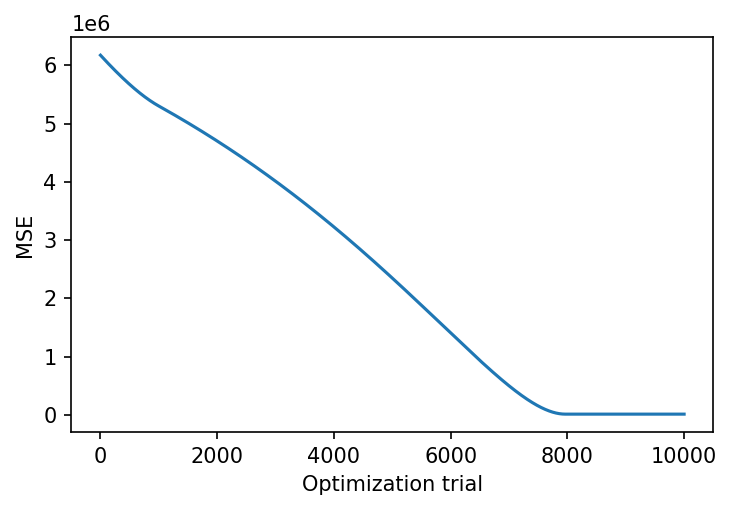

In [43]:
fig, ax = plt.subplots( figsize=(5,3.5), dpi=150 )
ax.plot( range(len(score_history)), score_history )
ax.set_ylabel( 'MSE' )
ax.set_xlabel( 'Optimization trial' )

fig.tight_layout()

#### So using this ***extremely naive*** optimization algorithm we fixed linear steps, we find that ~8k steps is enough to minimize our errors, and this is effectively due to only k changing in our function. We can clearly see this if we fix A=10k and iterate our values of k from 0.05 to 1.00



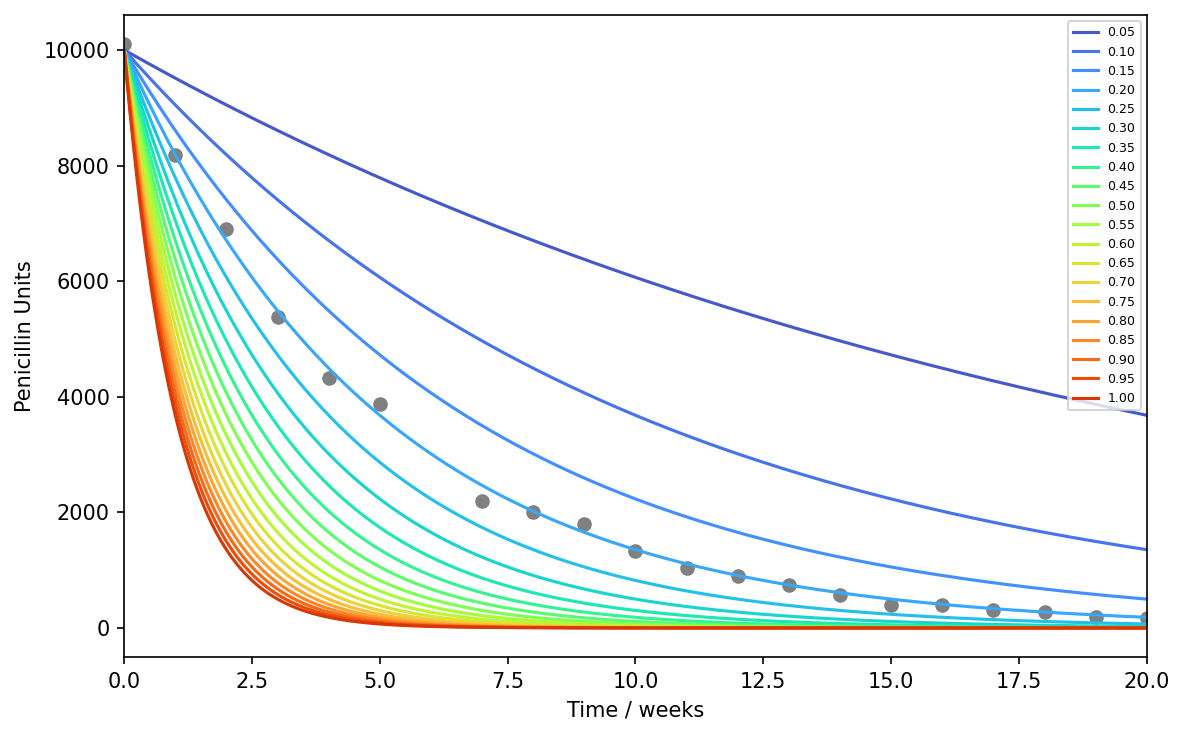

In [60]:
fig,ax = plt.subplots( figsize=(8,5), dpi=150 ) # Configure figure size and resolution in dots per inch (dpi)
ax.plot(xdata, ydata, 'o', c='grey') # plot the data using a scatter plot
ax.set_xlabel('Time / weeks')
ax.set_ylabel('Penicillin Units')

legend_font = FontProperties(size=6)

A = 1e4
k_values = np.linspace(0.05,1.0,20)

for i, k in enumerate(k_values):
    # Use i to compute the appropriate color for each line
    c_value = 0.8*i/len(k_values)+0.1
    c = cm.turbo(c_value)

    A = 1e4
    y_fit = first_order_rate(xt, A, k)
    ax.plot(xt, y_fit, c=c, label=format(k,'.2f'))

ax.set( xlim=xlim )
ax.legend(prop=legend_font)
fig.tight_layout()

#### Let's go one step further now: for one value of A, let's compute MSE~k

Best k = 0.202


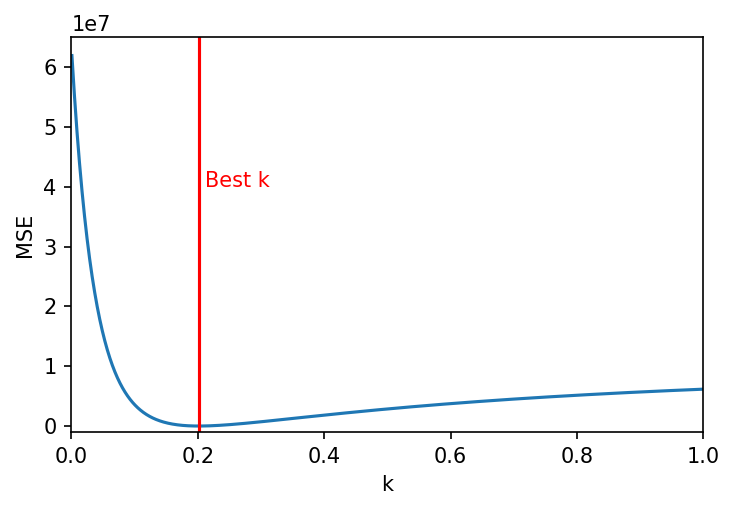

In [71]:
func = first_order_rate_log10A
log10_A = 4
k_values = np.linspace(0.001,1.0,1000)
mses = [ MSE(ydata, func(xdata, log10_A, k)) for k in k_values ]

fig, ax = plt.subplots( figsize=(5,3.5), dpi=150 )
ax.plot( k_values, mses )
ax.set_ylabel('MSE')
ax.set_xlabel('k')

min_i = np.argmin(mses)
best_k = k_values[min_i]
print( f'Best k = {best_k}' )

ylim = (-0.1e7,6.5e7)
ax.plot( [best_k]*2, ylim, c='red' )
ax.text( best_k+0.01, 4e7, 'Best k', color='red' )
ax.set(xlim=(0,1), ylim=ylim)
fig.tight_layout()


### The choice of **MSE** as our loss function has important statistical origins. Let us revisit the PDF for a Normal distribution with mean $\mu$ and variance $\sigma^2$

## $P(x|\mu,\sigma) = \frac{1}{\sqrt{2\pi}\sigma}e^{-(\frac{x-\mu}{\sigma})^{2}}$

#### If we compute the ***logP*** for any particular observation ***x***:

## $\ln P(x|\mu,\sigma)=-\ln{\sqrt{2\pi}\sigma}-(\frac{x-\mu}{\sigma})^2$

### If we want to *maximize* the probability of an observation, we should *minimize* the $-\ln P$, which for a constant $\sigma$ means we are **minimizing the MSE**

### The result is that, when we do **NLLS regression**, we are *indirectly* inferring $\sigma_{opt} \le \sigma_{any}$ by optimizing the model $y=f(x|\theta)+N(0,\sigma)$, with $\theta_{opt}$ being the parameters we are interested in.

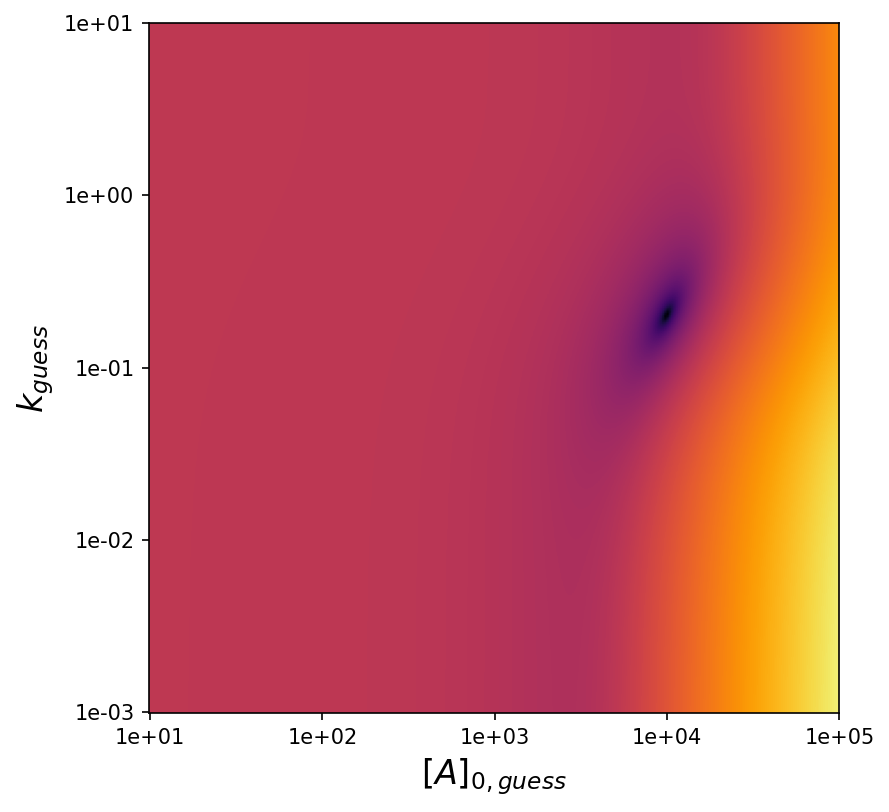

In [119]:
## Visualize the full parameter for multiple k/A_0 values

N = 300
k_log_min = -3
k_log_max = 1
A_log_min = 1
A_log_max = 5
func = first_order_rate

log10_kt = np.linspace(k_log_min, k_log_max, N)
log10_At = np.linspace(A_log_min, A_log_max, N)

kt = np.power(10.0,log10_kt)
At = np.power(10.0,log10_At)


sigma_array = np.zeros((N,N)) # Zero-filled matrix of size N x N that we will fill in with sigma values
for i, k in enumerate(kt):
    for j, A in enumerate(At):
        sigma = np.sqrt( MSE(ydata, func(xdata, A, k)) )
        sigma_array[i,j] = sigma




fig, ax = plt.subplots( figsize=(6,6), dpi=150 )

# Transform sigma to log scale for visualization
# Compute vmin/vmax for improved color scale
logsigma_array = np.log(sigma_array)
logsigma_min = np.min(logsigma_array)
logsigma_max = np.max(logsigma_array)
logsigma_range = logsigma_max - logsigma_min
logsigma_vmin = logsigma_min - 0.02*logsigma_range
logsigma_vmax = logsigma_max + 0.05*logsigma_range
ax.imshow(np.log(sigma_array), cmap='inferno', vmin=logsigma_vmin, vmax=logsigma_vmax, origin='lower'), 

# Generate y-axis labels
k_ticks = np.arange(k_log_min, k_log_max+1)
k_range = k_log_max - k_log_min
yticks = (k_ticks-k_log_min)/k_range*N
yticklabels = [ f'{np.power(10.0,k):.0e}' for k in k_ticks ]
ax.set_yticks(yticks)
ax.set_yticklabels( yticklabels )
ax.set_ylabel(r'$k_{guess}$', fontsize=16)

# Generate x-axis labels
A_ticks = np.arange(A_log_min, A_log_max+1)
A_range = A_log_max - A_log_min
xticks = (A_ticks-A_log_min)/A_range*N
xticklabels = [ f'{np.power(10.0,A):.0e}' for A in A_ticks ]
ax.set_xticks(xticks)
ax.set_xticklabels( xticklabels )
ax.set_xlabel(r'$[A]_{0,guess}$', fontsize=16)

ax.set_title( 'Ln($\sigma$)')

fig.tight_layout()


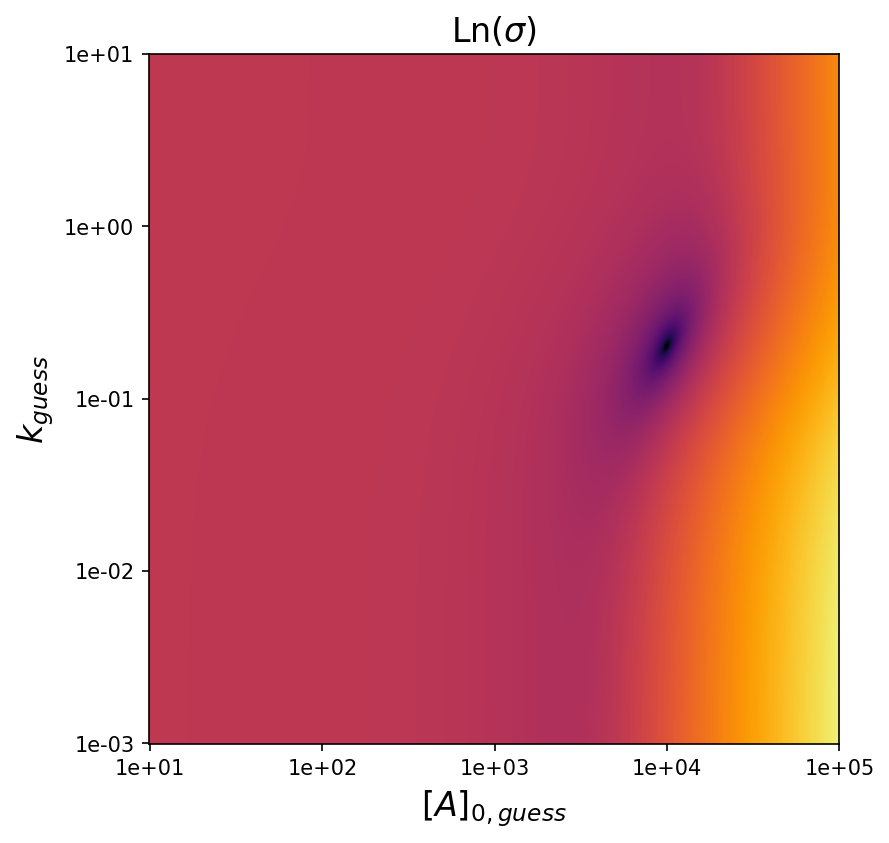

In [123]:
fig, ax = plt.subplots( figsize=(6,6), dpi=150 )

# Transform sigma to log scale for visualization
# Compute vmin/vmax for improved color scale
logsigma_array = np.log(sigma_array)
logsigma_min = np.min(logsigma_array)
logsigma_max = np.max(logsigma_array)
logsigma_range = logsigma_max - logsigma_min
logsigma_vmin = logsigma_min - 0.02*logsigma_range
logsigma_vmax = logsigma_max + 0.05*logsigma_range
ax.imshow(np.log(sigma_array), cmap='inferno', vmin=logsigma_vmin, vmax=logsigma_vmax, origin='lower'), 

# Generate y-axis labels
k_ticks = np.arange(k_log_min, k_log_max+1)
k_range = k_log_max - k_log_min
yticks = (k_ticks-k_log_min)/k_range*N
yticklabels = [ f'{np.power(10.0,k):.0e}' for k in k_ticks ]
ax.set_yticks(yticks)
ax.set_yticklabels( yticklabels )
ax.set_ylabel('$k_{guess}$', fontsize=16)

# Generate x-axis labels
A_ticks = np.arange(A_log_min, A_log_max+1)
A_range = A_log_max - A_log_min
xticks = (A_ticks-A_log_min)/A_range*N
xticklabels = [ f'{np.power(10.0,A):.0e}' for A in A_ticks ]
ax.set_xticks(xticks)
ax.set_xticklabels( xticklabels )
ax.set_xlabel('$[A]_{0,guess}$', fontsize=16)

ax.set_title( 'Ln($\sigma$)', fontsize=16)

fig.tight_layout()
